In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib as plt

C:\Users\yasha\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parse_data(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    pairs = data.split('--------------------\n')
    structured_data = []

    for pair in pairs:
        if not pair.strip():
            continue
        lines = pair.splitlines()
        #for line in lines[2:4]:
        #print(lines[2:4])
        #print("end")
        # Parse xi
        try:
            xi = np.fromstring(lines[1].split(': ')[1].strip("[]"), sep=' ')
        except (IndexError, ValueError):
            print(f"Skipping xi parsing due to format error in pair: {lines}")
            continue
        
        # Parse D (distance matrix)
        try:
            D_lines = [lines[2:4][0].split(': ')[1] + lines[2:4][1]]  # Extract only the numeric part
            #for row in D_lines:
            #    print(row)
            #print(D_lines)
            for row in D_lines:
                D_nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+", row)
            D =  np.array(D_nums, dtype=float)
            #print(D)
            #D = np.array([list(map(float, row.strip("[]").split())) for row in D_lines])
        except (IndexError, ValueError):
            print(f"Skipping D parsing due to format error in pair: {lines}")
            continue
        
        # Parse K
        try:
            K = np.fromstring(lines[4].split(': ')[1].strip("[]"), sep=' ')
        except (IndexError, ValueError):
            print(f"Skipping K parsing due to format error in pair: {lines}")
            continue
        
        # Parse solution
        try:
            solution_lines = [lines[5:][0].split(': ')[1] + lines[5:][1]]
            for S in solution_lines:
                S_nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+", S)
            solution =  np.array(S_nums, dtype=float)
            #solution = np.array([list(map(float, row.split())) for row in solution_lines])
        except (IndexError, ValueError):
            print(f"Skipping solution parsing due to format error in pair: {lines}")
            continue
        
        # Append to structured data
        structured_data.append({'xi': xi, 'D': D, 'K': K, 'solution': solution.flatten()})
        #print(f"Total processed pairs: {len(structured_data)}")

    return pd.DataFrame(structured_data)


In [4]:
file_path = "output_pairs.txt"  # Path to your data file
data = parse_data(file_path)
print(data.head)

<bound method NDFrame.head of                     xi                                                 D  \
0         [87.0, 14.0]  [1.55077269, 1.09112052, 1.43257147, 0.33185579]   
1        [199.0, 60.0]  [1.33004796, 1.65647278, 1.62584778, 0.41944166]   
2         [63.0, 74.0]  [0.85898501, 0.97660981, 0.57332625, 0.84110391]   
3         [37.0, 56.0]  [0.19823922, 0.04773849, 1.69957328, 0.67034252]   
4        [194.0, 27.0]     [0.4994225, 0.3644454, 1.7171356, 1.36434533]   
...                ...                                               ...   
102395  [119.0, 163.0]  [1.16610094, 1.79765429, 1.90499959, 1.07324322]   
102396   [153.0, 90.0]  [0.36937874, 0.55527475, 0.66739221, 1.82459368]   
102397   [79.0, 144.0]   [1.71443066, 0.46205486, 0.0691891, 1.98151513]   
102398   [62.0, 102.0]  [1.38878393, 0.58314555, 0.15654368, 0.12880419]   
102399   [156.0, 28.0]  [0.53097034, 0.59019165, 1.60526796, 0.15556779]   

                    K                      solution  
0  

In [13]:
data['xi_1'], data['xi_2'] = data['xi'].apply(lambda x: x[0]), data['xi'].apply(lambda x: x[1])
data['D_1_1'], data['D_1_2'], data['D_2_1'], data['D_2_2'] = zip(*data['D'].apply(lambda x: x.flatten()))
data['K_1'], data['K_2'] = data['K'].apply(lambda x: x[0]), data['K'].apply(lambda x: x[1])
data['S_1_1'], data['S_1_2'], data['S_2_1'], data['S_2_2'] = zip(*data['solution'].apply(lambda x: x.flatten()))
#print(data.head)

X = data[['xi_1', 'xi_2', 'D_1_1', 'D_1_2', 'D_2_1', 'D_2_2', 'K_1', 'K_2']]
#y = np.vstack(data['solution'])
y = np.vstack(data[['S_1_2', 'S_2_1']].to_numpy())
#print(y[0:10])
#print(y1[0:10])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sub_x_train = X_train[:1000]
sub_x_test = X_test[:1000]
sub_y_train = y_train[:1000]
sub_y_test = y_test[:1000]
sample = X.iloc[0:1]
print("sample to be predicted:\n")
print(sample)
print(f"Solution: {y[0]}")
print("\n")
subset = X_train.sample(1000, random_state=42)

sample to be predicted:

   xi_1  xi_2     D_1_1     D_1_2     D_2_1     D_2_2   K_1   K_2
0  87.0  14.0  1.550773  1.091121  1.432571  0.331856  29.0  16.0
Solution: [ 0. 16.]




In [18]:
print("RANDOM FOREST MODE\n")

# Step 4: Model fitting
#model = RandomForestRegressor(random_state=42)
#model.fit(X_train, y_train)

model = RandomForestRegressor(random_state=42)
model.fit(sub_x_train, sub_y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
#print(y_pred[0:10])
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  # Calculate R² score

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

RANDOM FOREST MODE

Mean Squared Error: 67.58571921382725
Mean Absolute Error (MAE): 5.29666562580743
R² Score: 0.9332065273331398


In [19]:
prediction = model.predict(sample)
print(f"Prediction: {prediction}")
print("----------------------------------------------------\n")

Prediction: [[ 3.09640293 17.70808594]]
----------------------------------------------------



In [20]:
scaler = StandardScaler()
sub_x_train = scaler.fit_transform(sub_x_train)
sub_x_test = scaler.transform(sub_x_test)

shap.initjs()
#background = shap.sample(X_train, 50)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sub_x_test[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[:,0], sub_x_test[0,:])
print(sub_x_train.shape)
print(sub_x_test.shape)
print(shap_values.shape)
#shap.summary_plot(shap_values, sub_x_test)

(1000, 8)
(1000, 8)
(8, 2)


In [21]:
sub_x_train = pd.DataFrame(sub_x_train, columns=X.columns)
sub_x_test = pd.DataFrame(sub_x_test, columns=X.columns)
#subset = X_test.sample(100, random_state=42)  # Reduce the size to 100 samples

print(sub_x_test.shape)

(1000, 8)


c:\Users\yasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
c:\Users\yasha\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


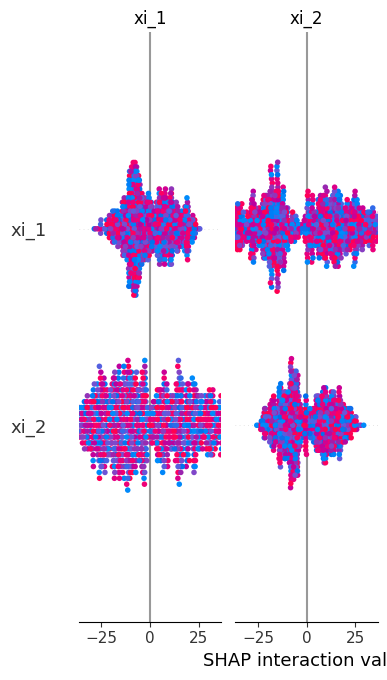

(1000, 8, 2)


In [26]:
shap_values_subset = explainer.shap_values(subset)
shap.summary_plot(shap_values_subset, sub_x_test)
print(shap_values_subset.shape)

(1000, 8)
(1000, 8)


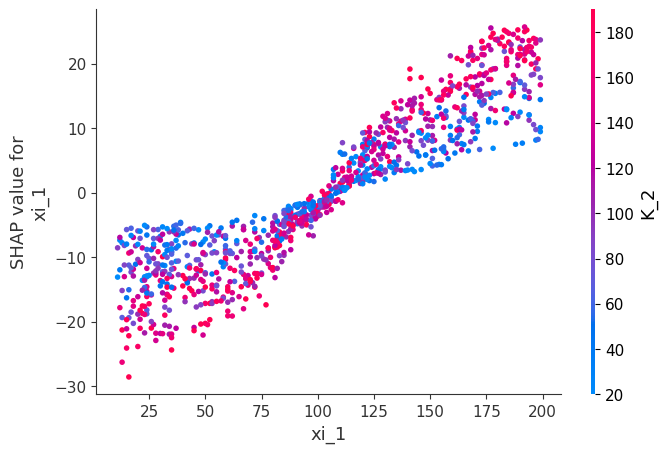

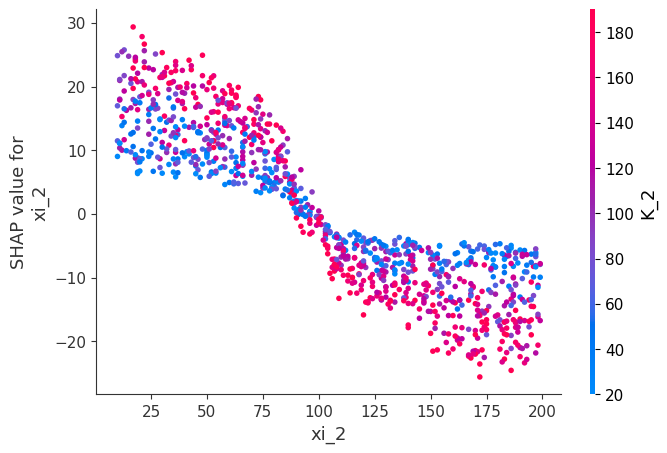

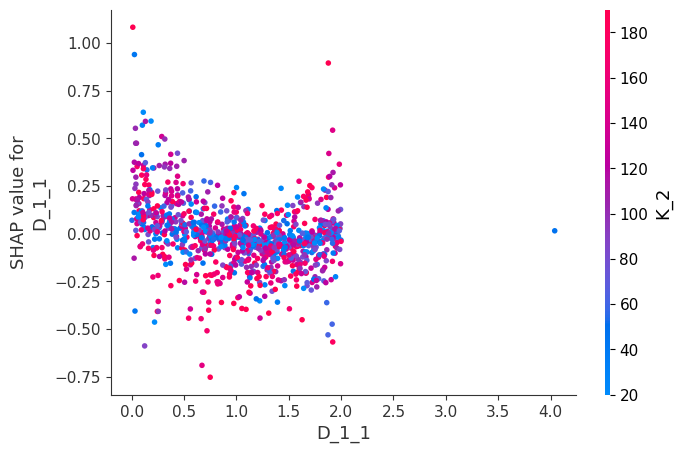

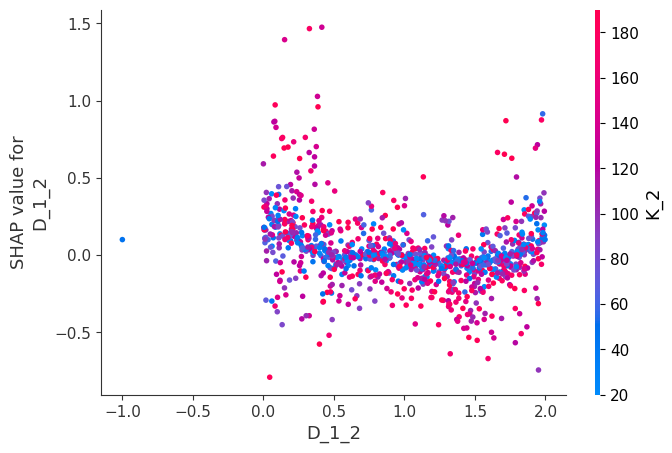

In [28]:
shap_values_single_class = shap_values_subset[:, :, 1]
print(shap_values_single_class.shape)
print(sub_x_test.shape)
shap.dependence_plot(0, shap_values_single_class, subset)
shap.dependence_plot(1, shap_values_single_class, subset)
shap.dependence_plot(2, shap_values_single_class, subset)
shap.dependence_plot(3, shap_values_single_class, subset)